# Cavity-QED in the dispersive regime with eHe

Author: K. V. Shulga (kirill-shulga@oist.jp)

In [685]:
%matplotlib inline

In [686]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [687]:
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numpy import *
from qutip import *

from IPython.display import HTML
from matplotlib import animation
from qutip import *
from scipy.constants import e, h, Boltzmann, hbar, k, m_e, epsilon_0, mu_0
from scipy.sparse import csr_matrix
from scipy.sparse import spdiags, diags
from scipy.fft import dct, idct, dst, idst
import scipy.linalg as scl

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import re


import matplotlib.tri as mtri 
import os
import time

from PIL import Image
from scipy.linalg import sqrtm, expm
from scipy.sparse.linalg import eigs
import scipy.linalg as la
import statistics

In [688]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [6]:
from scipy.constants import e, h, Boltzmann, hbar, k, m_e, epsilon_0, mu_0

In [7]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
ep4  = 1.0572                          # the relative permittivity of 4He
ep32 = 1.0462                          # the relative permittivity of 3He
ep3  = 1.042                           # the relative permittivity of 3He (in Monakha's book)
ep0  = epsilon_0                       # the electric constant (vacuum permittivity) [C^2 Nm^-2]
mu0  = mu_0                            # the magnetic constant [Tm/A]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]
mb   = 9.2740100783e-24                # Bohr Magneton [J T^-1]
kB   = Boltzmann

Joule_to_GHz = 1.5092e+24

# Plotting experimental data

In [8]:
with open("out.csv", "r+", encoding='utf-8') as f:
    data=re.split('\n', f.read())

In [6]:
voltage = [] 
frequency = []
amp = []
phase = []

for i in data:
        voltage.append(float(i.split(' ')[0])*5)
        frequency.append(float(i.split(' ')[1])/1e9)
        amp.append(float(i.split(' ')[4]))
        phase.append(float(i.split(' ')[5]))

In [7]:
voltages = linspace (voltage[0], voltage[-1], int(size(voltage)/800))  
frequencies = linspace (frequency[0], frequency[-1], 800)
freq_range = int(size(frequencies))
voltages_range = int(size(voltages))

In [8]:
# Создаем двумерную матрицу-сетку
xgrid, ygrid = meshgrid(frequencies,voltages)

# В узлах рассчитываем значение функции
zgrid_amp = xgrid+ygrid
zgrid_phase = xgrid+ygrid

freq_range = int(size(frequencies))
voltages_range = int(size(voltages))

In [9]:
for i in arange(0, voltages_range, 1):
    for j in arange(0, freq_range, 1):
        zgrid_amp[i][j]=amp[i*freq_range+j]
        zgrid_phase[i][j]=phase[i*freq_range+j]

In [10]:
zgrid_phase_nbg = xgrid+ygrid
for i in arange(0, voltages_range, 1):
    for j in arange(0, freq_range, 1):
        zgrid_phase_nbg[i][j] = zgrid_phase[i][j] - zgrid_phase[-1][j]

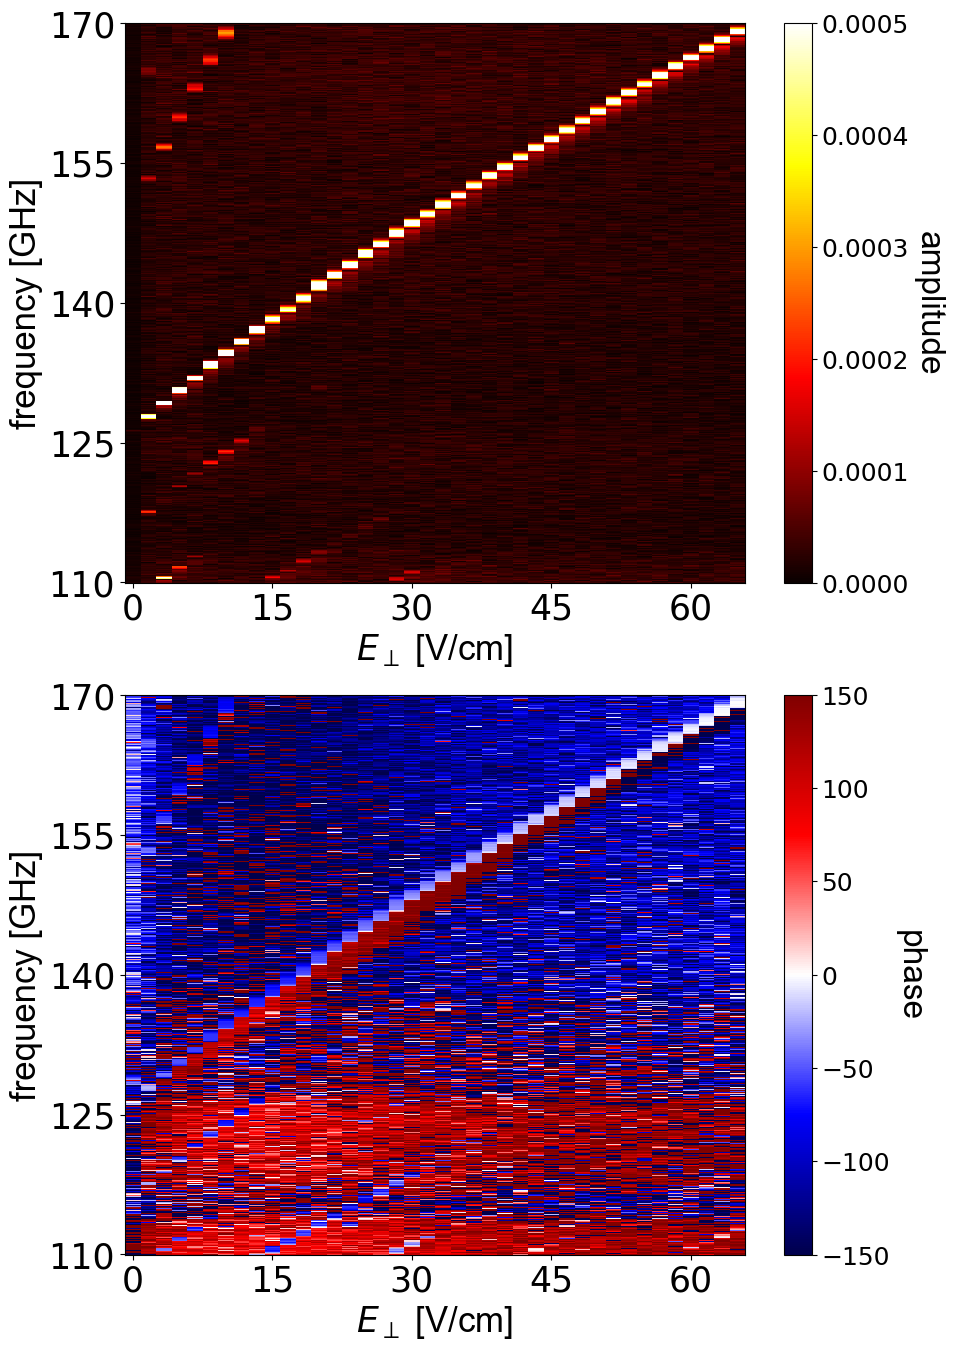

In [11]:
hfont = {'fontname':'Arial'}

fig, axes = plt.subplots(2,1, figsize=(10, 16))

#plt.ylim(0,0.65)
#plt.xlim(0,150)
#axes.axis('tight')

p = axes[0].pcolor(ygrid, xgrid, zgrid_amp, cmap=cm.hot, shading='auto', vmin = 0 , vmax = 0.0005)

axes[0].set_ylabel(r'frequency [GHz]', fontsize=25, **hfont)
axes[0].set_xlabel(r'$E_\perp$ [V/cm]', fontsize=25, **hfont)

axes[0].tick_params(axis='x', labelsize=25)
axes[0].tick_params(axis='y', labelsize=25)


axes[0].set_yticks(np.round(np.linspace(xgrid[0][0], xgrid[0][-1], 5), 2))
axes[0].set_xticks(np.round(np.linspace(ygrid[-1][0], 60, 5), 2))

cb = fig.colorbar(p, ax=axes[0])
cb.set_label(r'amplitude', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 


p = axes[1].pcolor(ygrid, xgrid, zgrid_phase, cmap=cm.seismic, shading='auto', vmin = -150 , vmax = 150)
#p = axes[1].pcolor(ygrid, xgrid, zgrid_phase_nbg, cmap=cm.seismic, shading='auto', vmin = -150 , vmax = 150)

axes[1].set_ylabel(r'frequency [GHz]', fontsize=25, **hfont)
axes[1].set_xlabel(r'$E_\perp$ [V/cm]', fontsize=25, **hfont)

axes[1].tick_params(axis='x', labelsize=25)
axes[1].tick_params(axis='y', labelsize=25)

axes[1].set_yticks(np.round(np.linspace(xgrid[0][0], xgrid[0][-1], 5), 2))
axes[1].set_xticks(np.round(np.linspace(ygrid[-1][0], 60, 5), 2))

cb = fig.colorbar(p, ax=axes[1])
cb.set_label(r'phase', labelpad=25, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18) 


#matplotlib.pyplot.text(0.91, 0.91,'(a)', fontsize=24, verticalalignment='center', transform=axes.transAxes)
#plt.gcf().set_size_inches(10,8)
#plt.savefig("C:/Users/Kirill Shulga/Desktop/primary_spectrum.png", bbox_inches="tight")

# Triangular lattice properties

In [806]:
electron_density = 2.25*10**7   # electron density [cm]^-2
#electron_density = 1.5*10**10
#electron_density = 1000*10**7 
X_SIZE = 100
Y_SIZE = 100
LATTICE_CONSTANT = sqrt(2/sqrt(3))/np.sqrt(electron_density)/100
#X_SHIFT = 0.00
#Y_SHIFT = 0.00
#ROTATION_ANGLE = 1/180*np.pi
print('Lattice constant: ',LATTICE_CONSTANT, 'm')

Lattice constant:  2.26539232646283e-06 m


In [807]:
X_SIZE*LATTICE_CONSTANT*1e9

226539.23264628302

In [808]:
#lattice 

x = []
for i in arange(Y_SIZE):
    for j in arange(X_SIZE):
        if i%2:
            x.append((j+0.5)*LATTICE_CONSTANT)
        else:
            x.append((j)*LATTICE_CONSTANT)

y = []
for i in arange(Y_SIZE):
    for j in arange(X_SIZE):
        y.append(i*LATTICE_CONSTANT * np.sin(np.pi/3))  
        
triangles = []

for i in arange(Y_SIZE-1):
    for j in arange(X_SIZE-1):
        if i%2:
            triangles.append(np.array([j+X_SIZE*(i+1),j+X_SIZE*(i+1)+1,j+X_SIZE*i]))
            triangles.append(np.array([j+i*X_SIZE,j+1+i*X_SIZE,j+X_SIZE+i*X_SIZE+1]))
        else:
            triangles.append(np.array([j+i*X_SIZE,j+1+i*X_SIZE,j+X_SIZE+i*X_SIZE]))       #четные ряды
            triangles.append(np.array([j+(i+1)*X_SIZE,j+(i+1)*X_SIZE+1,j+1+(i)*X_SIZE]))
            

In [809]:
x=x-LATTICE_CONSTANT*5
y=y-LATTICE_CONSTANT*4*np.sin(np.pi/3)-LATTICE_CONSTANT*sqrt(3)/1/3

Text(0, 0.5, 'Y [m]')

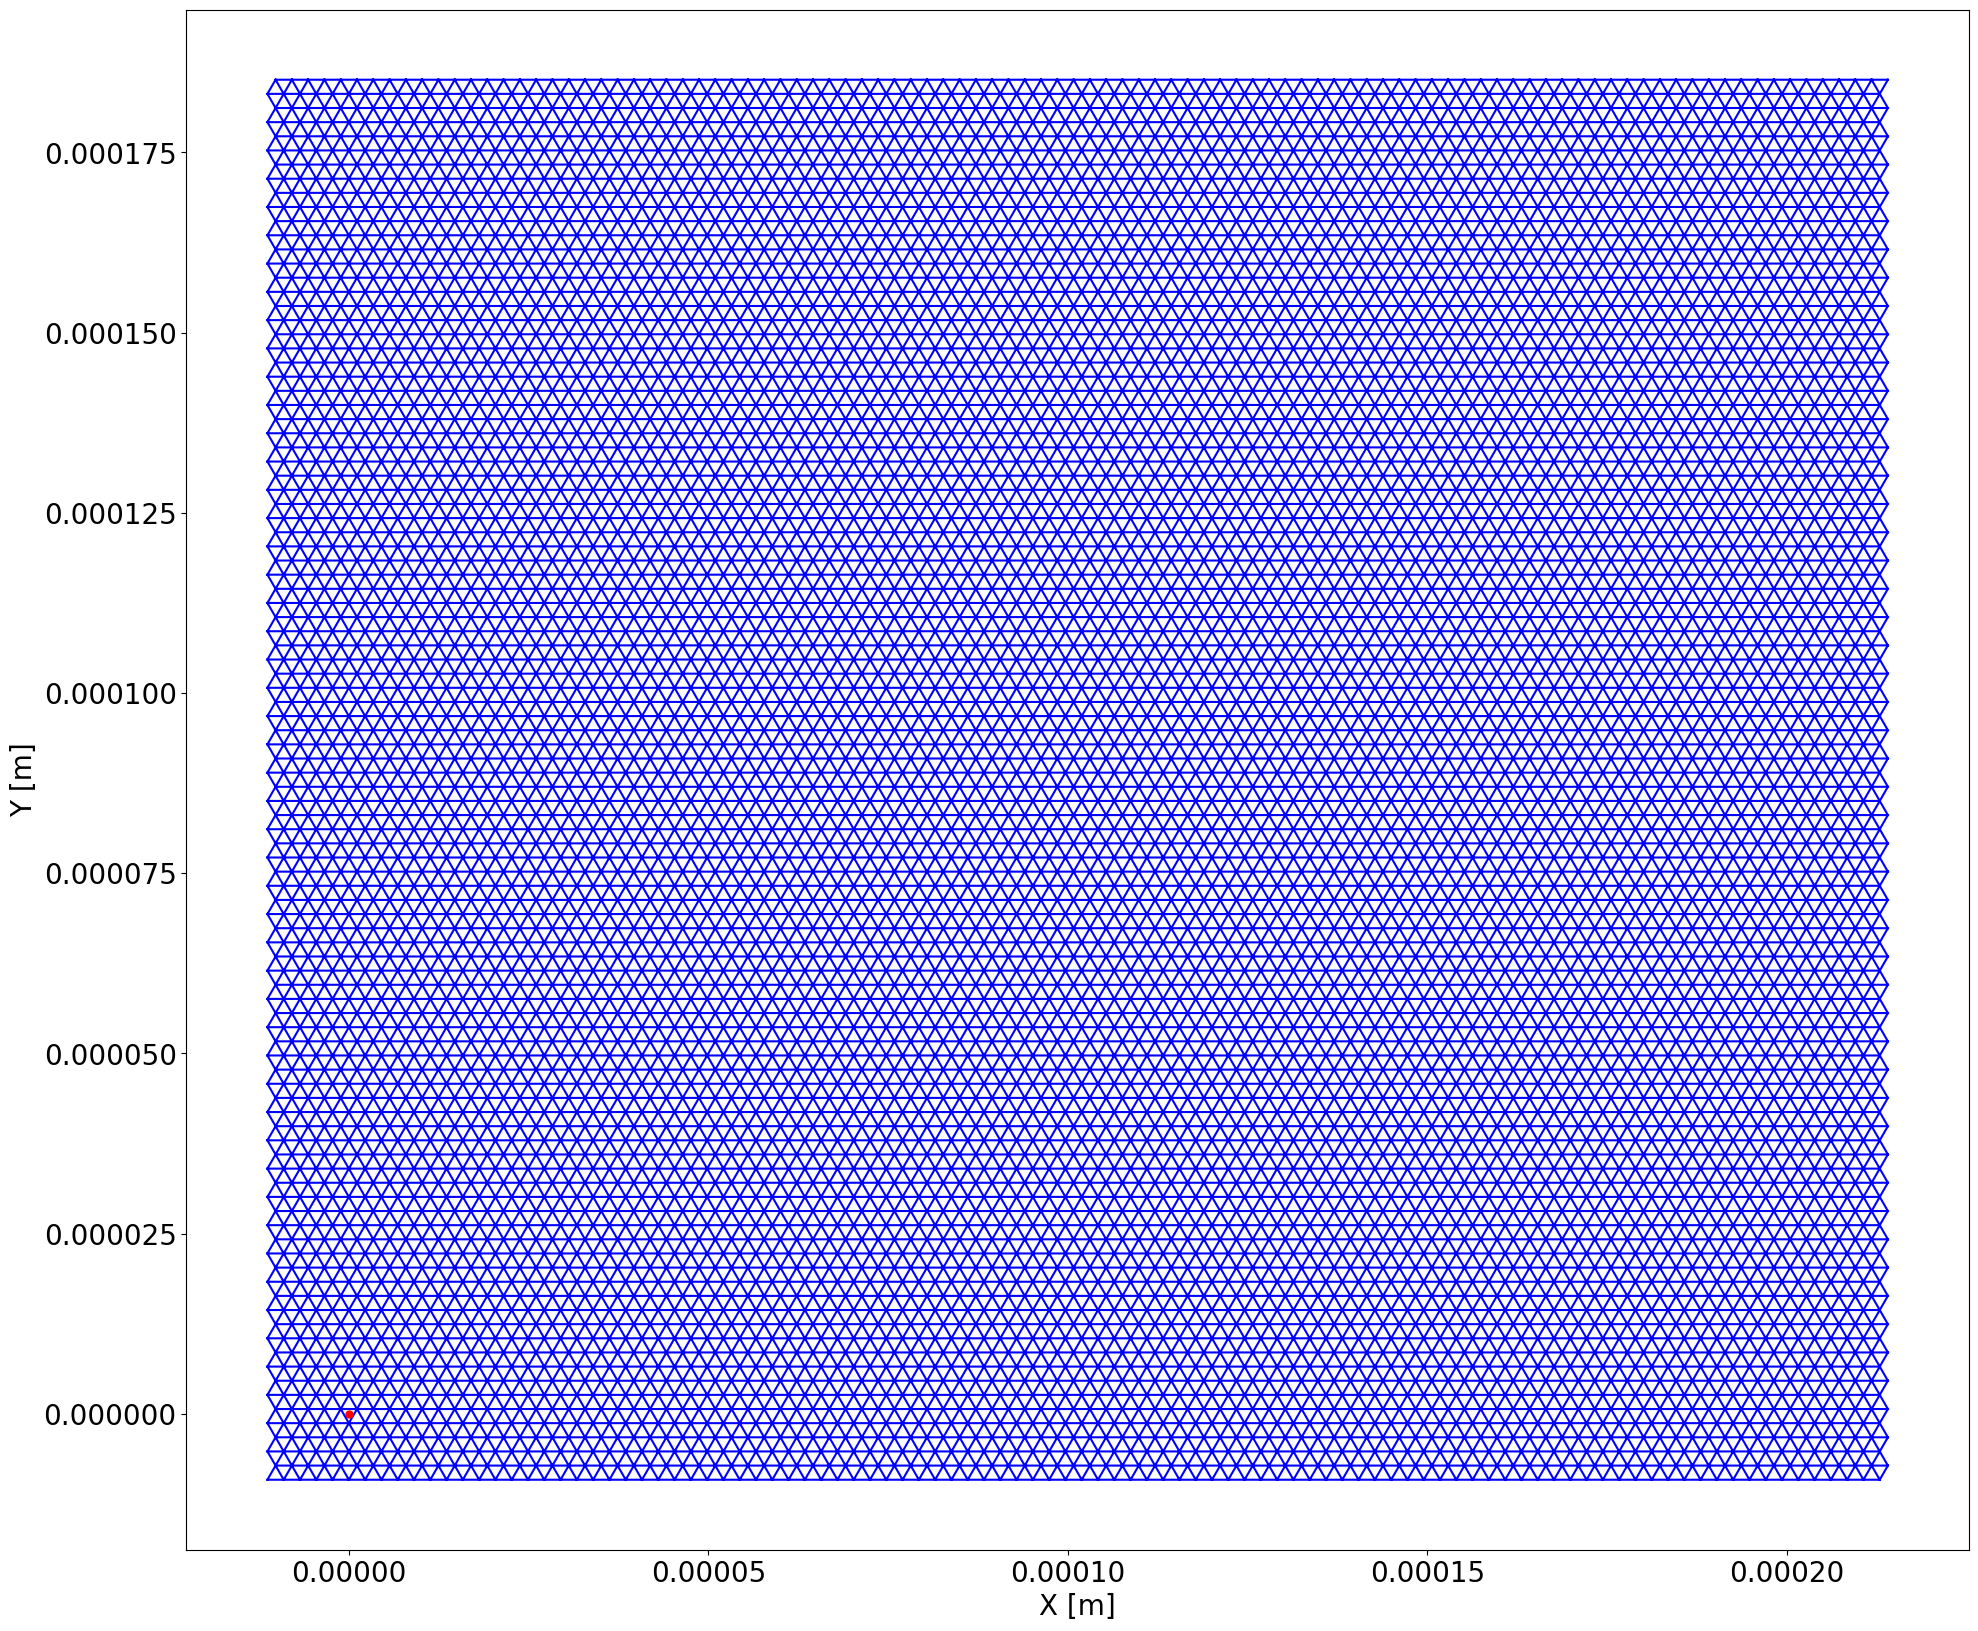

In [810]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(23, 20))
triang = mtri.Triangulation(x, y, triangles) 
p = axes.triplot(triang, 'b-')   
plt.plot(0, 0, marker = "o", color ='r', markersize = 5)

axes.tick_params(axis ='x', labelsize = 20)
axes.tick_params(axis ='y', labelsize = 20)
axes.set_xlabel(r'X [m]', fontsize=20)
axes.set_ylabel(r'Y [m]', fontsize = 20)

In [811]:
distances = []

for i_id, i_value in enumerate(x):
    distances.append(sqrt(x[i_id]**2+y[i_id]**2))    

In [812]:
def wigner_potential(z, d):
    U = 0
    for i in d:
        U = U + 1/4/ep0/pi*qe**2/(sqrt(z**2+i**2))
        #U = U + 1/4/ep0/pi*qe**2/(sqrt(z**2+i**2))*sin(arctan(z/i))
    return U

In [813]:
def wigner_force(z, d):
    F = 0
    for i in d:
        F = F + 1/4/ep0/pi*qe**2/(z**2+i**2)*sin(arctan(z/i))
    return F

In [814]:
z = linspace(0, 20000e-9, 3000)
pot = []
for i in z:
    pot.append(wigner_potential(i, distances))

Text(0.5, 0, 'Distance from Helium [nm]')

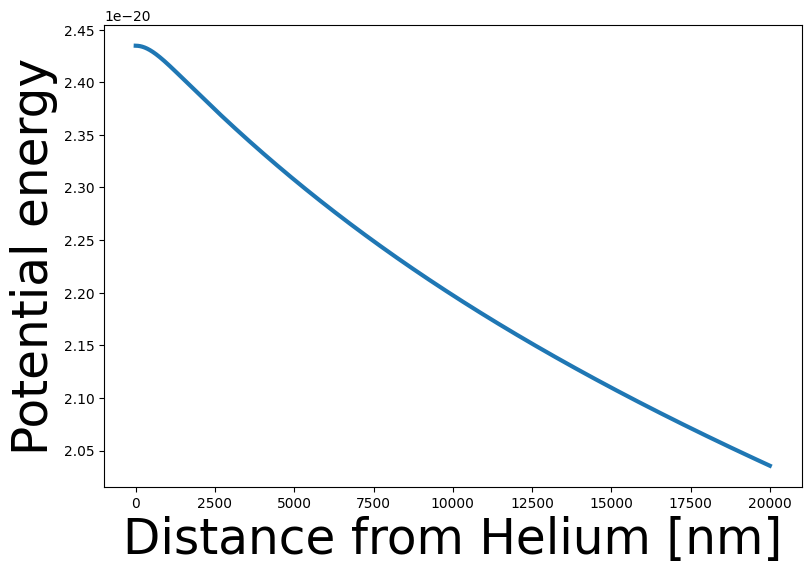

In [815]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

p = axes.plot(z*1e9, pot , linewidth=3.0)

axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]


# Saturation of the repulsion force

In [754]:
z = linspace(0, 40000e-9, 4000)
    
electron_density = 2.25*10**7   # electron density [cm]^-2

X_SIZE = 10
Y_SIZE = 10
LATTICE_CONSTANT = sqrt(2/sqrt(3))/np.sqrt(electron_density)/100

#print('Lattice constant: ',LATTICE_CONSTANT, 'm')

In [755]:
def construct_potential(X_SIZE, Y_SIZE, LATTICE_CONSTANT, z):
    #lattice 

    x = []
    for i in arange(Y_SIZE):
        for j in arange(X_SIZE):
            if i%2:
                x.append((j+0.5)*LATTICE_CONSTANT)
            else:
                x.append((j)*LATTICE_CONSTANT)

    y = []
    for i in arange(Y_SIZE):
        for j in arange(X_SIZE):
            y.append(i*LATTICE_CONSTANT * np.sin(np.pi/3))  
                
    x = x - LATTICE_CONSTANT*X_SIZE/2
    y = y - LATTICE_CONSTANT*Y_SIZE/2*np.sin(np.pi/3)-LATTICE_CONSTANT*sqrt(3)/2/3
    
    distances = []

    for i_id, i_value in enumerate(x):
        distances.append(sqrt(x[i_id]**2+y[i_id]**2))  
        
    pot = []
    for i in z:
        pot.append(wigner_potential(i, distances))
        
    return pot

In [756]:
pot = construct_potential(6, 6, LATTICE_CONSTANT, z)

Text(0.5, 0, 'Distance from Helium [nm]')

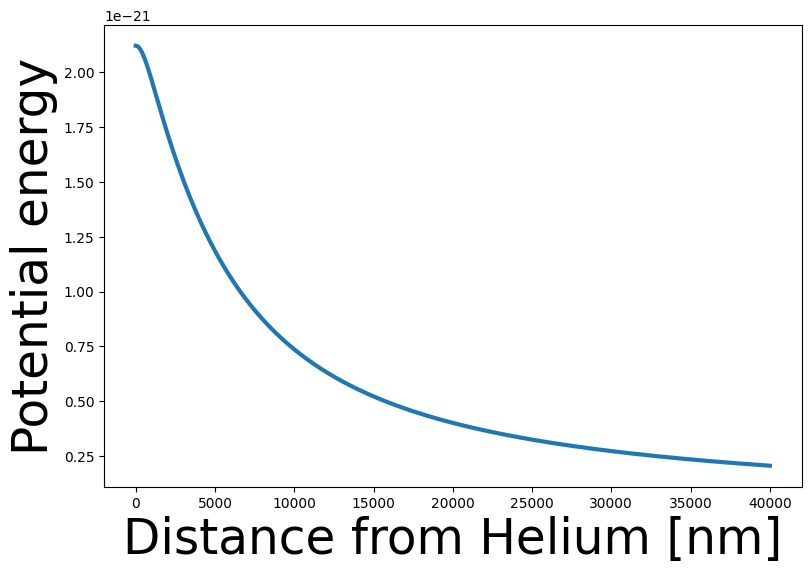

In [757]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

p = axes.plot(z*1e9, pot , linewidth=3.0)

axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]

In [761]:
lattice_size = np.array([2,6,10,14,18,22])

In [768]:
lattice_size = np.array([6,10,102,202])

In [759]:
102/4+1

26.5

In [760]:
lattice_size = linspace(2,102,26)

In [205]:
lattice_size = np.array([2,6,10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,80,94,98,102,106,110,114,118,142,170,194,226,270,302])

In [769]:
pot = []
for i in lattice_size:
    pot.append(construct_potential(i, i, LATTICE_CONSTANT, z))

Text(0.5, 0, 'Distance from Helium [nm]')

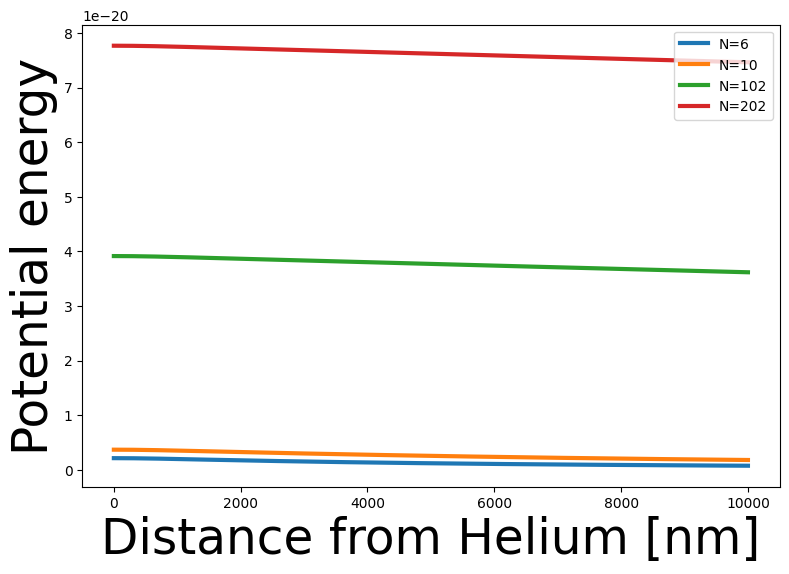

In [776]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

for i_id, i_value in enumerate(pot):
    p = axes.plot(z*1e9, i_value, label='N=%i' % lattice_size[i_id], linewidth=3.0)
    
plt.legend()
axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]

Text(0.5, 0, 'Distance from Helium [nm]')

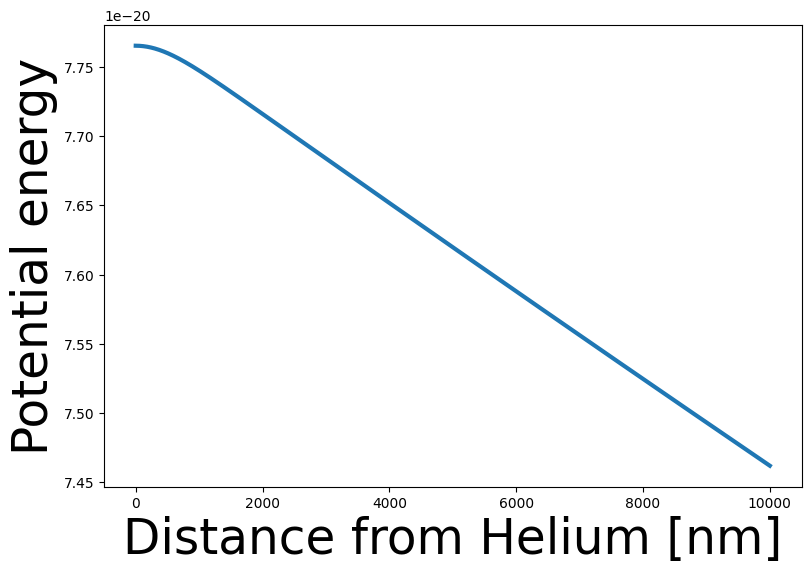

In [781]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))
p = axes.plot(z*1e9, pot[3],  linewidth=3.0)

axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]

In [764]:
z = linspace(0, 10000e-9, 1000)
    
electron_density = 2.25*10**7   # electron density [cm]^-2

X_SIZE = 10
Y_SIZE = 10
LATTICE_CONSTANT = sqrt(2/sqrt(3))/np.sqrt(electron_density)/100

#print('Lattice constant: ',LATTICE_CONSTANT, 'm')

In [765]:
def construct_force(X_SIZE, Y_SIZE, LATTICE_CONSTANT, z):
    #lattice 

    x = []
    for i in arange(Y_SIZE):
        for j in arange(X_SIZE):
            if i%2:
                x.append((j+0.5)*LATTICE_CONSTANT)
            else:
                x.append((j)*LATTICE_CONSTANT)

    y = []
    for i in arange(Y_SIZE):
        for j in arange(X_SIZE):
            y.append(i*LATTICE_CONSTANT * np.sin(np.pi/3))  
    
                
    x = x - LATTICE_CONSTANT*X_SIZE/2
    y = y - LATTICE_CONSTANT*Y_SIZE/2*np.sin(np.pi/3)-LATTICE_CONSTANT*sqrt(3)/2/3
    
    distances = []

    for i_id, i_value in enumerate(x):
        distances.append(sqrt(x[i_id]**2+y[i_id]**2))  
        
    force = []
    for i in z:
        force.append(wigner_force(i, distances))
        
    return force

In [245]:
lattice_size = np.array([2,6,10,58,110,202,302])

In [202]:
lattice_size = np.array([2,6,10,14,18,22,26,30,34,38,42,46,50,54,58,62,66,80,94,98,102,106,110,114,118,142,170,194,226,270,302])

In [766]:
force = []
for i in lattice_size:
    force.append(construct_force(i, i, LATTICE_CONSTANT, z))

Text(0.5, 0, 'Distance from Helium [nm]')

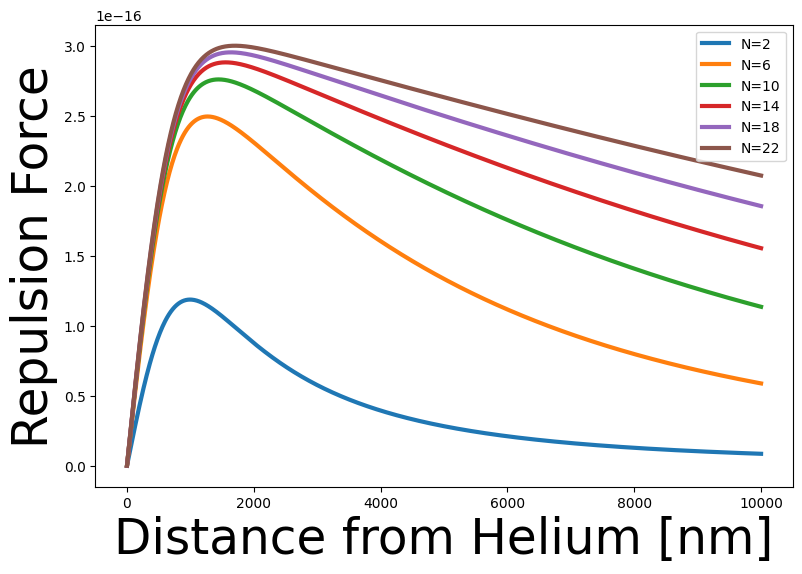

In [767]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

for i_id, i_value in enumerate(force):
    p = axes.plot(z*1e9, i_value, label='N=%i' % lattice_size[i_id], linewidth=3.0)
    
plt.legend()
axes.set_ylabel('Repulsion Force', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]

### Problem parameters

Physical constants definition (in SI units)

In [816]:
l4  = qe**2 / 4 * ( ep4 - 1) / ( ep4 + 1) / 4 / ep0 / pi      # the Coulomb constant for 4He
c3  = qe**2 / 4 / ep0 / pi                                    # the Coulomb constant for the wigner cristal

print('The attraction to the reflection in the electron layer is', c3/l4, 'times greater than the attraction to the helium')

The attraction to the reflection in the electron layer is 143.86013986014004 times greater than the attraction to the helium


In [884]:
Ez = 3.2*5*100                       # perpendicular Electric field [V/cm*100]
Ez_array = np.array([2.1,2.5,2.9,3.3,3.7])*5*100
#Ez_array = np.array([0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1.0,1.1,1.2])*5*100

Then we construct the Hamiltonian $𝐻_𝑧$ and solve it by finding its eigenvalues

In [885]:
nsolz = 2                                   # The number of energy levels we are interested in           
nz = 5000                                  # Number of vertical axis sampling steps
az = 40000e-9                               # Maximum altitude above helium level [m]
dz = az/(nz)                                # Vertical axis step
zgrid = asarray(range(1,nz+1,1)) * dz       # Discretization of the vertical axis

In [886]:
zgrid = asarray(range(1,nz+1,1)) * dz #+ 50e-9      # Discretization of the vertical axis

constructing the Vertical Hamiltonian

In [887]:
V_He       = -l4/zgrid
V_reflect  = -c3/zgrid
V_stark    = qe*Ez*zgrid
V_wigner   = wigner_potential(zgrid, distances)

In [888]:
Vz  = V_He + V_stark + V_wigner + V_reflect 
Vz_noe  = V_stark + V_wigner 

Text(0.5, 0, 'Distance from Helium [nm]')

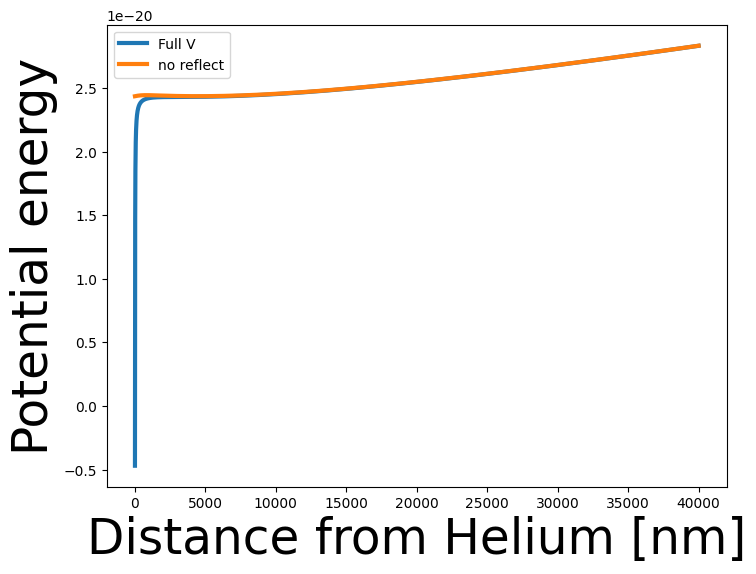

In [889]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(8, 6))

#p = axes.plot(zgrid*1e9, V_He ,label="He image charge", linewidth=3.0)
#p = axes.plot(zgrid*1e9, V_reflect ,label="electrons image charge", linewidth=3.0)
#p = axes.plot(zgrid*1e9, V_wigner ,label="Wigner repulsion", linewidth=3.0)
#p = axes.plot(zgrid*1e9, V_stark ,label="Stark potential", linewidth=3.0)

p = axes.plot(zgrid*1e9, Vz ,label="Full V", linewidth=3.0)
p = axes.plot(zgrid*1e9, Vz_noe ,label="no reflect", linewidth=3.0)


plt.legend()
axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]
#axes.set_xlim(0,17000)
#axes.set_ylim(0.46e-20,0.66e-20)
#axes.set_ylim(1.675e-20,1.7e-20)

In [877]:
print('Minimum of the top well', round(zgrid[argmin(Vz[500:])+500]*1e9,0), 'nm')

Minimum of the top well 4008.0 nm


Text(0.5, 0, 'Distance from Helium [nm]')

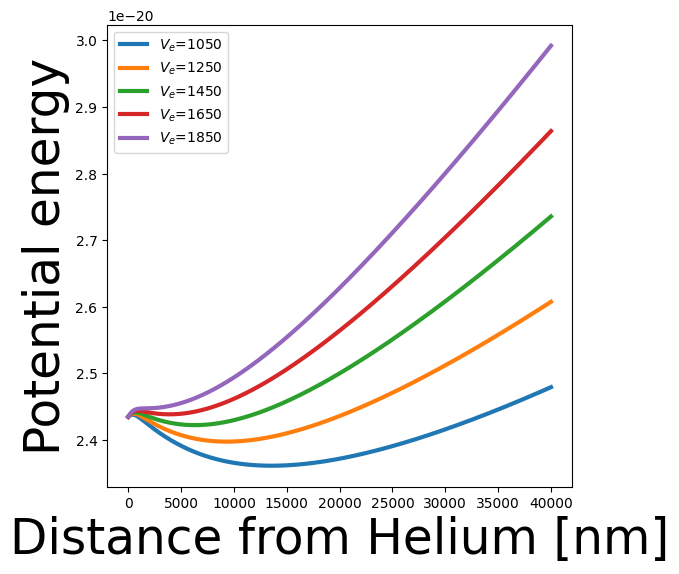

In [839]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(6, 6))

for i in Ez_array:
    p = axes.plot(zgrid*1e9, qe*i*zgrid + V_wigner, label='$V_e$=%i' % i, linewidth=3.0)


plt.legend()
axes.set_ylabel('Potential energy', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]
#axes.set_xlim(100,20000)
#axes.set_ylim(0.3e-20,0.7e-20)

# Horizintal potential

In [416]:
electron_density = 2.25*10**7   # electron density [cm]^-2
#electron_density = 5.5*10**6
#electron_density = 1000*10**7 
X_SIZE = 102
Y_SIZE = 102
LATTICE_CONSTANT = sqrt(2/sqrt(3))/np.sqrt(electron_density)/100
#X_SHIFT = 0.00
#Y_SHIFT = 0.00
#ROTATION_ANGLE = 1/180*np.pi
print('Lattice constant: ',LATTICE_CONSTANT, 'm')

Lattice constant:  2.26539232646283e-06 m


In [417]:
def construct_hor_potential(x,y, LATTICE_CONSTANT, z, point_x, point_y):
    
    distances = []

    for i_id, i_value in enumerate(x):
        distances.append(sqrt((x[i_id]-point_x)**2+(y[i_id]-point_y)**2))  
        
    pot = wigner_potential(z, distances)
        
    return pot

In [423]:
x_sweep = np.linspace(-4*LATTICE_CONSTANT,4*LATTICE_CONSTANT,200)
y_sweep = np.linspace(-4*LATTICE_CONSTANT,4*LATTICE_CONSTANT,200)
pots = np.zeros((200,200), dtype=float)

In [424]:
x = []
for i in arange(Y_SIZE):
    for j in arange(X_SIZE):
        if i%2:
            x.append((j+0.5)*LATTICE_CONSTANT)
        else:
            x.append((j)*LATTICE_CONSTANT)

y = []
for i in arange(Y_SIZE):
    for j in arange(X_SIZE):
        y.append(i*LATTICE_CONSTANT * np.sin(np.pi/3))  
        
triangles = []

for i in arange(Y_SIZE-1):
    for j in arange(X_SIZE-1):
        if i%2:
            triangles.append(np.array([j+X_SIZE*(i+1),j+X_SIZE*(i+1)+1,j+X_SIZE*i]))
            triangles.append(np.array([j+i*X_SIZE,j+1+i*X_SIZE,j+X_SIZE+i*X_SIZE+1]))
        else:
            triangles.append(np.array([j+i*X_SIZE,j+1+i*X_SIZE,j+X_SIZE+i*X_SIZE]))       #четные ряды
            triangles.append(np.array([j+(i+1)*X_SIZE,j+(i+1)*X_SIZE+1,j+1+(i)*X_SIZE]))
            
x = x-LATTICE_CONSTANT*X_SIZE/2
y = y-LATTICE_CONSTANT*X_SIZE/2*np.sin(np.pi/3)-LATTICE_CONSTANT*sqrt(3)/2/3

In [425]:
for i_id, i_value in enumerate(x_sweep):
    for j_id, j_value in enumerate(y_sweep):
        pots[i_id][j_id] = construct_hor_potential(x, y, LATTICE_CONSTANT, zgrid[argmin(Vz[500:])+500], i_value, j_value)
        #pots[i_id][j_id] = construct_hor_potential(x, y, LATTICE_CONSTANT, zgrid[200], i_value, j_value)

In [426]:
zgrid[200]*1e9

804.0

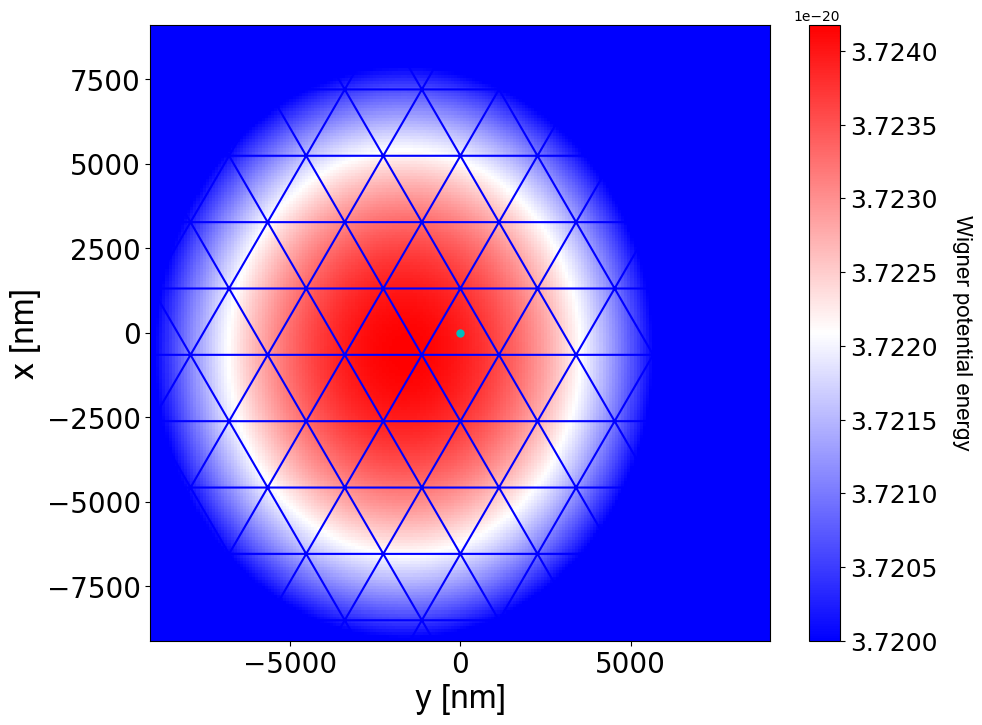

In [431]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(10, 8))

p = axes.pcolor(x_sweep*1e9, y_sweep*1e9,  pots, cmap=cm.bwr, shading='auto', vmin=3.72e-20)

axes.axis('tight')
axes.set_ylabel(r'x [nm]', fontsize=24, **hfont)
axes.set_xlabel(r'y [nm]', fontsize=24, **hfont)

#axes.set_xlim(5.00,6.9)
#axes.set_ylim(-0.2,0.6)

axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

cb = fig.colorbar(p, ax = axes)
cb.set_label(r'Wigner potential energy', labelpad=25, rotation=270, fontsize=16, **hfont)
cb.ax.tick_params(labelsize=18) 

triang = mtri.Triangulation(x*1e9, y*1e9, triangles) 
p = axes.triplot(triang, 'b-')   
plt.plot(0, 0, marker = "o", color ='c',markersize = 5)

In [890]:
def Lap(N, h):   
    #Laplace operator
    operator = 1./(h*h)*(diag(ones(N-1),-1) - 2*diag(ones(N),0) + diag(ones(N-1),1))
    return operator

In [891]:
lap = (-0.5)*((hb**2)/me)*Lap(nz,dz)           # the momentum term
#Hz  = -lap + diag(Vz)                          # the total z Hamiltonian
Hz  = -lap + diag(Vz_noe)

In [892]:
Ez_eigh, psizT = linalg.eigh(Hz)              # the eigenvalues and eigenvectors
psiz = transpose(psizT)                       # transpose of psiT to the wavefunction vectors

In [893]:
print('Rydberg frequency:', (Ez_eigh[1]-Ez_eigh[0])*Joule_to_GHz , 'GHz')
print('Anharmonicity:', (Ez_eigh[2]-Ez_eigh[1]-((Ez_eigh[1]-Ez_eigh[0])))*Joule_to_GHz, 'GHz')

Rydberg frequency: 0.623972087169059 GHz
Anharmonicity: -0.0002050936712838483 GHz


In [894]:
for i in range(20):
    print((Ez_eigh[i+1]-Ez_eigh[i]) * Joule_to_GHz)

0.623972087169059
0.6237669934977752
0.6235617337998216
0.6233563031112472
0.6231506963545618
0.6229449083114857
0.6227389337046991
0.6225327670752184
0.6223264028005632
0.6221198351810461
0.6219130584443143
0.6217060665182709
0.621498853303569
0.6212914125282817
0.6210837378069426
0.6208758224952149
0.6206676599669282
0.6204592432780013
0.6202505654434788
0.6200416192240763


Plotting wave functions of electrons at different Rydberg levels

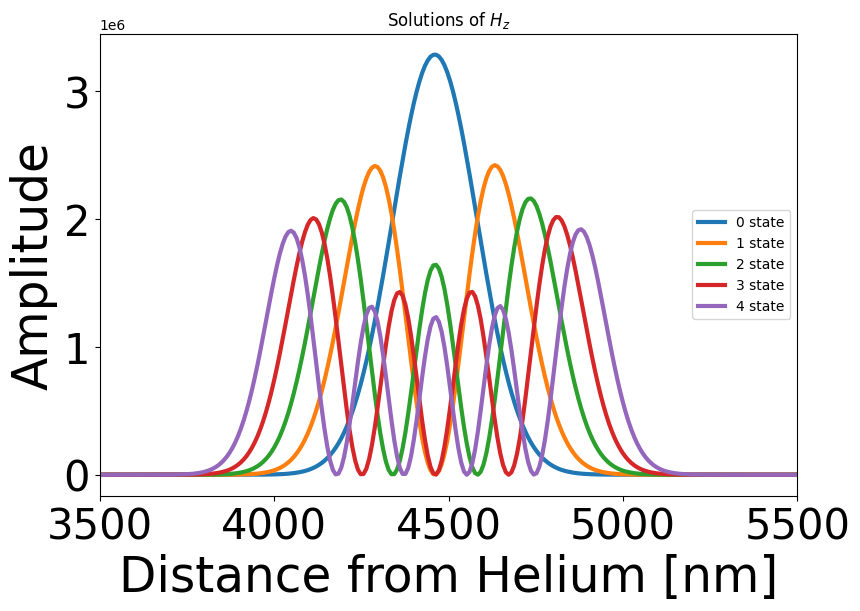

In [898]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,1,figsize=(9, 6))

for i in range(nsolz+3):
    #p = axes.plot(zgrid*10, psiz[i]**2/dz,label="$f_{}$ ={:>8.3f} GHz".format(i,(Ez_eigh[i]-Ez_eigh[0]) * (R/h/1e9)), linewidth=3.0)
    p = axes.plot(zgrid*1e9, psiz[i]**2/dz,label="{:>1.0f} state".format( i), linewidth=3.0)
    plt.title("Solutions of $H_z$")
    #p = axes.plot(zgrid[argmax(psiz[i]**2/dz)]*10, max(psiz[i]**2/dz), marker="o", markersize = 5)
    
    #plt.text(zgrid[argmax(psiz[i]**2/dz)], max(psiz[i]**2/dz), 'b', fontsize=24,transform=axes.transAxes)

plt.legend(loc = 'center right')
axes.set_ylabel('Amplitude', fontsize=35)
axes.set_xlabel('Distance from Helium [nm]', fontsize=35)   #[$\AA$]
axes.set_xlim(3500,5500)
#plt.show()

#matplotlib.pyplot.text(170, 0.52, '(a)', fontsize=40, weight="black",  verticalalignment='center')

axes.tick_params(axis='x', labelsize=30)
axes.tick_params(axis='y', labelsize=30)

#plt.gcf().set_size_inches(9,6)
#plt.savefig("C:/Users/Kirill/Desktop/SolutionsHz.pdf", bbox_inches="tight")

In [145]:
for i in range(nsolz+20):
    print(zgrid[argmax(psiz[i]**2/dz)]*10)

5.344e-05
5.512000000000001e-05
5.6080000000000005e-05
5.6800000000000005e-05
5.7440000000000006e-05
5.8e-05
5.848000000000001e-05
5.896e-05
5.944e-05
5.984000000000001e-05
6.016000000000001e-05
6.056e-05
6.088e-05
6.128000000000001e-05
6.16e-05
6.184e-05
6.216e-05
6.248e-05
6.272e-05
6.304e-05
6.328e-05
6.36e-05


In [146]:
for i in range(nsolz+20):
    print(zgrid[argmax(psiz[i+1]**2/dz)]*10-zgrid[argmax(psiz[i]**2/dz)]*10)

1.6800000000000042e-06
9.599999999999976e-07
7.199999999999999e-07
6.400000000000006e-07
5.599999999999946e-07
4.80000000000009e-07
4.799999999999886e-07
4.800000000000022e-07
4.000000000000097e-07
3.1999999999999694e-07
3.9999999999999617e-07
3.1999999999999694e-07
4.000000000000097e-07
3.1999999999999694e-07
2.399999999999977e-07
3.1999999999999694e-07
3.1999999999999694e-07
2.399999999999977e-07
3.200000000000105e-07
2.399999999999977e-07
3.1999999999999694e-07
2.399999999999977e-07
